<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_Active_Learning_Solution_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Active Learning on MRI Brain Tumor Classification
brain-tumor-mri-dataset<br>
Dataset-1: Labelled Dataset<br>
Source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
Type of images = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
Total number of MRI slices = 5712<br>

Dataset-2: Unlabelled Dataset<br>
Source: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification <br>
Total number of MRI slices = 1311<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/1*D_LnIlqZFdE2lPvMsj_U8Q.png" alt="Sample Image" width="400">

In [1]:
!gdown 1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
!unzip -q braintumor.zip

Downloading...
From (original): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
From (redirected): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1&confirm=t&uuid=a6bd049b-84c6-45aa-a629-83af2eb4e01c
To: /content/braintumor.zip
100% 130M/130M [00:10<00:00, 13.0MB/s]


Dataset details:

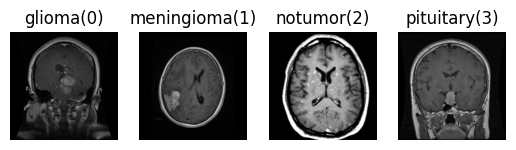

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Training/glioma/Tr-gl_0026.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Training/meningioma/Tr-meTr_0007.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Training/notumor/Tr-noTr_0003.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Training/pituitary/Tr-piTr_0002.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Dataloader

In [3]:
import os
import sys
from torchvision import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import Counter

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

# Mapping of class indices to class names
class_to_idx = dataset_.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print split information
print(f"Total samples: {len(dataset_)}")
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Mapping of class: {idx_to_class}")

Total samples: 5712
Training samples: 4569
Validation samples: 1143
Mapping of class: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


#Evaluation on labelled dataset
The training process of ResNet model can be found here: https://github.com/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Training_ReseNet.ipynb<br>

Download the pretrained weights:

In [4]:
!gdown 1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU

Downloading...
From: https://drive.google.com/uc?id=1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU
To: /content/best_model_4.pth.tar
100% 85.3M/85.3M [00:03<00:00, 22.6MB/s]


Evaluate the performance:

In [9]:
from torchvision import models
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
validloader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, validloader)
print('accuracy: {:.3f}%'.format(accuracy*100))

accuracy: 96.413%


#Active Learning on new dataset:

Download new dataset

In [10]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
To: /content/braintumor_v2.zip
100% 25.6M/25.6M [00:01<00:00, 18.2MB/s]


Visualizing new dataset:

total images: 1311


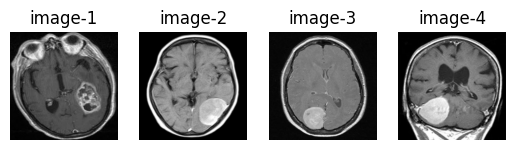

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
img_path_all = glob('braintumor_v2/*/*.jpg')
print('total images:', len(img_path_all))

class_names = ['image-1', 'image-2', 'image-3', 'image-4']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0001.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0004.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor_v2/meningioma/Te-me_0010.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor_v2/meningioma/Te-me_0020.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Uncertainty-based sampling:

Sample size of new dataset: 1311
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Number of high-uncertainty samples selected: 131


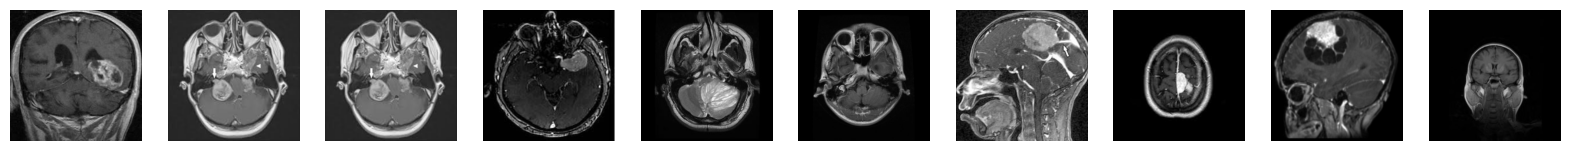

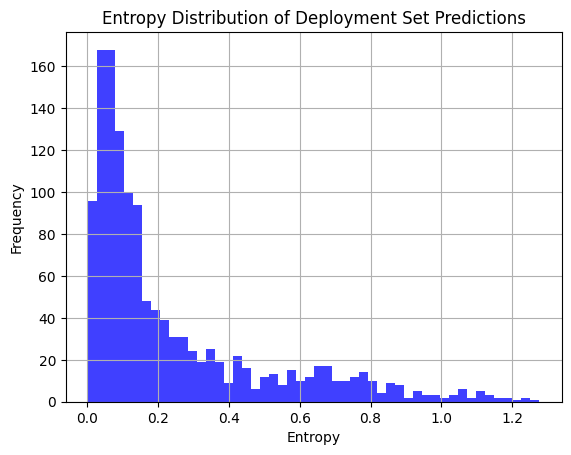

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings("ignore")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to get entropy-based uncertainty
def get_uncertainty(model, dataloader):
    model.eval()
    entropy_list = []
    indices_list = []  # Store indices to map back to dataset

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values and sample indices
            start_idx = batch_idx * dataloader.batch_size
            entropy_list.extend(entropy.cpu().numpy())
            indices_list.extend(range(start_idx, start_idx + len(inputs)))

    entropy_array = np.array(entropy_list)
    return entropy_array, indices_list

# Prepare dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

print('Sample size of new dataset:', len(new_dataset))
newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)

# Prepare model
num_classes = len(new_dataset.classes)
model = models.resnet34(weights=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))

# Get uncertainty values and indices
entropy_array, sample_indices = get_uncertainty(model, newdataloader)

# Print some statistics about uncertainty
print(f"Average entropy: {np.mean(entropy_array):.4f}")
print(f"Max entropy: {np.max(entropy_array):.4f}")
print(f"Min entropy: {np.min(entropy_array):.4f}")

# Sort indices based on entropy values (descending order)
sorted_indices = np.argsort(entropy_array)[::-1]  # Sort in descending order

# Select the top 10% samples
top_10_percent = int(0.10 * len(new_dataset))
high_uncertainty_indices = [sample_indices[i] for i in sorted_indices[:top_10_percent]]

# Create a new dataset with high-uncertainty samples
high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

# Retrieve paths of the high-uncertainty samples
all_image_paths = [new_dataset.samples[i][0] for i in range(len(new_dataset))]
high_uncertainty_image_paths = [all_image_paths[idx] for idx in high_uncertainty_indices]

# Print the number of selected high-uncertainty samples
print(f"Number of high-uncertainty samples selected: {len(high_uncertainty_subset)}")

# Create DataLoader for the selected subset (optional)
high_uncertainty_loader = DataLoader(high_uncertainty_subset, batch_size=64, shuffle=False)


# Function to visualize the most uncertain samples after denormalization
def visualize_high_uncertainty_samples( indices, paths, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, img_path in enumerate(paths[:num_samples]):
        image = Image.open(img_path)
        resized_image = image.resize((224, 224))
        axes[i].imshow(resized_image)
        axes[i].axis('off')

    plt.show()

# Visualize top 10 highest uncertainty samples with their file paths
visualize_high_uncertainty_samples( high_uncertainty_indices, high_uncertainty_image_paths)

# Print some statistics about uncertainty
plt.hist(entropy_array, bins=50, alpha=0.75, color='blue')
plt.title("Entropy Distribution of Deployment Set Predictions")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#Whole Pipeline- Active Learning (Uncertainty Sampling): Retrain the model on 10% highest uncertain samples after labeling them

In [13]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)
#Set GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=5, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

def get_high_uncertained_indices(new_dataset):
    newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)
    model_ = models.resnet34(weights=True)
    model_.fc = nn.Linear(model_.fc.in_features, 4)
    model_.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))
    model_.to(device)

    model_.eval()
    entropy_list = []
    indices_list = []  # Store indices to map back to dataset

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(newdataloader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model_(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values and sample indices
            start_idx = batch_idx * newdataloader.batch_size
            entropy_list.extend(entropy.cpu().numpy())
            indices_list.extend(range(start_idx, start_idx + len(inputs)))

    entropy_array = np.array(entropy_list)

    # Print some statistics about uncertainty
    print(f"Average entropy: {np.mean(entropy_array):.4f}")
    print(f"Max entropy: {np.max(entropy_array):.4f}")
    print(f"Min entropy: {np.min(entropy_array):.4f}")

    # Sort indices based on entropy values (descending order)
    sorted_indices = np.argsort(entropy_array)[::-1]  # Sort in descending order

    # Select the top 10% samples
    top_10_percent = int(0.10 * len(new_dataset))
    high_uncertainty_indices = [sample_indices[i] for i in sorted_indices[:top_10_percent]]
    return high_uncertainty_indices


if __name__ == '__main__':
    args = get_arguments()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    # Prepare original dataset
    dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.2

    # Calculate lengths for each split
    total_size = len(dataset_)
    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    # Perform the split
    train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])
    print('Training on:', device, 'train sample size:', len(train_split), 'valid sample size:', len(val_split))

    # Prepare new dataset
    new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Get high uncertainity indices
    high_uncertainty_indices = get_high_uncertained_indices(new_dataset)

    # Create a new dataset with high-uncertainty samples
    high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

    # Merge the subsets
    merged_dataset = ConcatDataset([high_uncertainty_subset, train_split])
    print('Training on:', device, 'merged train sample size:', len(merged_dataset), 'valid sample size:', len(val_split))

    # Prepare dataloader
    trainloader = DataLoader(merged_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    print(dataset_.class_to_idx)

    model = models.resnet34(weights=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.3f}  best epoch: {}  best acc: {:.3f}'.format(
                epoch, accuracy*100, best_epoch, best_acc*100, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 4569 valid sample size: 1143
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Training on: cuda merged train sample size: 4700 valid sample size: 1143
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
epoch: 0  acc: 98.163  best epoch: 0  best acc: 98.163
epoch: 1  acc: 98.600  best epoch: 1  best acc: 98.600
epoch: 2  acc: 98.425  best epoch: 1  best acc: 98.600
epoch: 3  acc: 98.863  best epoch: 3  best acc: 98.863
epoch: 4  acc: 98.425  best epoch: 3  best acc: 98.863


#Active Learning - Density Sampling

Visualizing image distribution with tSNE plot (embedding level)

sample size of new dataset: 1311
Total dimension after t-SNE reduction: (1311, 2)


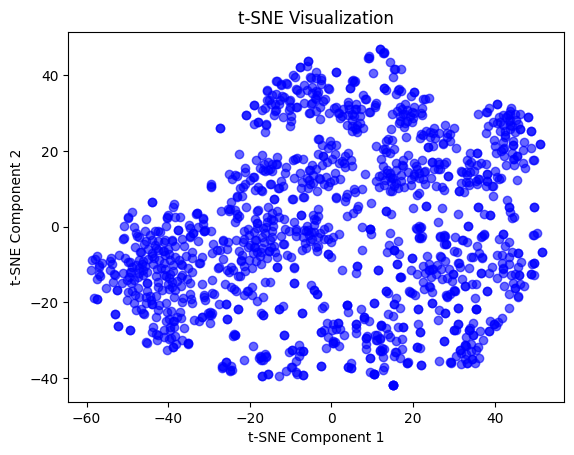

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Plot without labels
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, color='blue')  # Single color

ax.set_title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()

Plot the images into expected label number (4 clusters):

sample size of new dataset: 1311


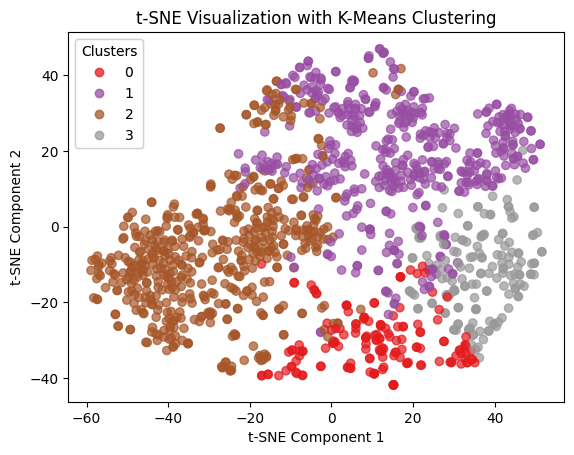

In [15]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

# Apply K-Means clustering to infer labels
num_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(img_all)

# Plot with inferred cluster labels
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

ax.set_title('t-SNE Visualization with K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()


Sample size of new dataset: 1311
Number of representative samples selected: 129


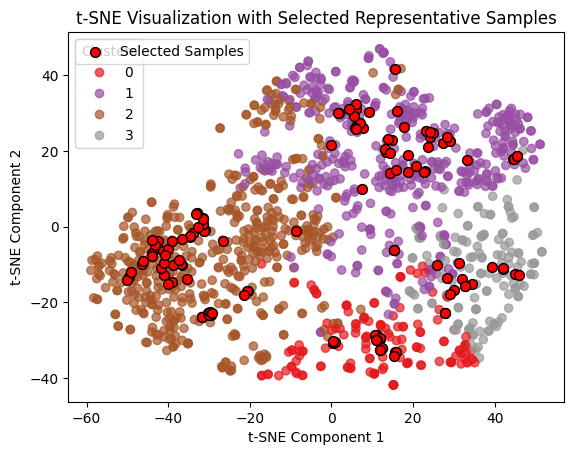

In [16]:
from sklearn.cluster import KMeans
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

print('Sample size of new dataset:', len(new_dataset))

# Prepare image data for clustering
img_all = []
for data, _ in new_dataset:
    img_all.append(np.array(data)[0, :, :])  # Convert tensor to numpy and extract first channel

img_all = np.array(img_all).reshape(len(new_dataset), 28 * 28)

# Perform t-SNE dimensionality reduction for visualization
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

# Apply K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(img_all)

# Calculate distances of each sample to its assigned cluster centroid
distances = np.linalg.norm(img_all - kmeans.cluster_centers_[cluster_labels], axis=1)

# Select 10% closest samples from each cluster
selected_indices = []
for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices of samples in the cluster
    cluster_distances = distances[cluster_indices]  # Get distances within the cluster

    # Get indices of top 10% closest samples
    top_10_percent = int(len(cluster_indices) * 0.10)
    closest_samples_indices = cluster_indices[np.argsort(cluster_distances)[:top_10_percent]]

    selected_indices.extend(closest_samples_indices)

# Create a subset dataset with selected samples
representative_subset = Subset(new_dataset, selected_indices)

# Print number of selected samples
print(f"Number of representative samples selected: {len(representative_subset)}")

# Visualize selected points on the t-SNE plot
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)
ax.scatter(X_embedded[selected_indices, 0], X_embedded[selected_indices, 1],
           color='red', edgecolors='black', label='Selected Samples', s=50)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
ax.set_title('t-SNE Visualization with Selected Representative Samples')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


#Whole Pipeline- Active Learning (Density Sampling):Retrain the model on 10% highest density samples after labeling them

In [20]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import random
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)
#Set GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=5, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

def get_densisty_indices():
    # Load dataset
    new_dataset_ = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

    print('Sample size of new dataset:', len(new_dataset_))

    # Prepare image data for clustering
    img_all = []
    for data, _ in new_dataset_:
        img_all.append(np.array(data)[0, :, :])  # Convert tensor to numpy and extract first channel

    img_all = np.array(img_all).reshape(len(new_dataset_), 28 * 28)

    # Perform t-SNE dimensionality reduction for visualization
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

    # Apply K-Means clustering
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(img_all)

    # Calculate distances of each sample to its assigned cluster centroid
    distances = np.linalg.norm(img_all - kmeans.cluster_centers_[cluster_labels], axis=1)

    # Select 10% closest samples from each cluster
    densisty_indices = []
    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices of samples in the cluster
        cluster_distances = distances[cluster_indices]  # Get distances within the cluster

        # Get indices of top 10% closest samples
        top_10_percent = int(len(cluster_indices) * 0.10)
        closest_samples_indices = cluster_indices[np.argsort(cluster_distances)[:top_10_percent]]

        densisty_indices.extend(closest_samples_indices)
    return selected_indices


if __name__ == '__main__':
    args = get_arguments()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    # Prepare original dataset
    dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.2

    # Calculate lengths for each split
    total_size = len(dataset_)
    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    # Perform the split
    train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])
    print('Training on:', device, 'train sample size:', len(train_split), 'valid sample size:', len(val_split))

    # Prepare new dataset
    new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Get high uncertainity indices
    densisty_indices = get_densisty_indices()

    # Create a new dataset with high-uncertainty samples
    # high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

    # Create a subset dataset with selected samples
    density_subset = Subset(new_dataset, densisty_indices)

    # Merge the subsets
    merged_dataset = ConcatDataset([density_subset, train_split])
    print('Training on:', device, 'merged train sample size:', len(merged_dataset), 'valid sample size:', len(val_split))

    # Prepare dataloader
    trainloader = DataLoader(merged_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    print(dataset_.class_to_idx)

    model = models.resnet34(weights=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.3f}  best epoch: {}  best acc: {:.3f}'.format(
                epoch, accuracy*100, best_epoch, best_acc*100, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 4569 valid sample size: 1143
Sample size of new dataset: 1311
Training on: cuda merged train sample size: 4698 valid sample size: 1143
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
epoch: 0  acc: 93.788  best epoch: 0  best acc: 93.788
epoch: 1  acc: 97.375  best epoch: 1  best acc: 97.375
epoch: 2  acc: 98.513  best epoch: 2  best acc: 98.513
epoch: 3  acc: 98.600  best epoch: 3  best acc: 98.600
epoch: 4  acc: 98.775  best epoch: 4  best acc: 98.775


#Active Learning - Diversity Sampling

sample size of labelled training dataset: 4569
Total dimension after t-SNE reduction: (4569, 2)


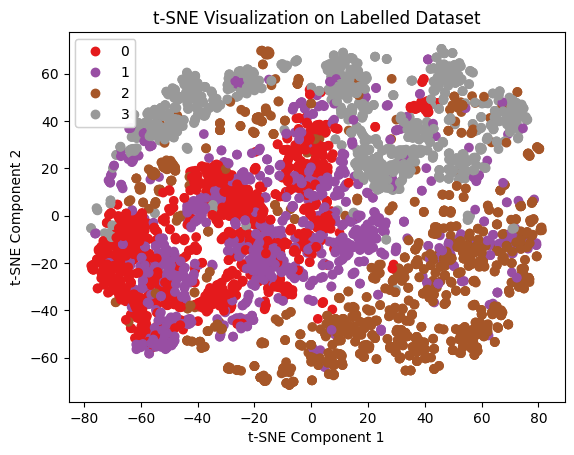

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Prepare original dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

print('sample size of labelled training dataset:', len(train_split))

img_all = []
label_all = []
for data, lab in train_split:
    img_all.append(np.array(data)[0,:,:])
    label_all.append(lab)


img_all = np.array(img_all).reshape(len(train_split),28*28)
label_all = np.array(label_all)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Plot without labels
fig, ax = plt.subplots()
# ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, color='blue')  # Single color
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")

ax.set_title('t-SNE Visualization on Labelled Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.add_artist(legend)
plt.show()
plt.close()

Sample size of labelled training dataset: 5712
Sample size of new dataset: 1311
Total dimension after t-SNE reduction: (5712, 2)
Number of least similar samples selected: 129


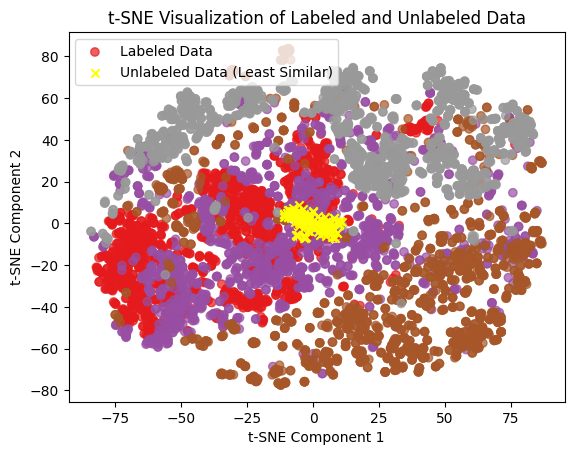

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Prepare original dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Load unlabeled dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labelled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Prepare images and labels for labelled dataset
img_all = []
label_all = []
for data, lab in dataset_:
    img_all.append(np.array(data)[0, :, :])
    label_all.append(lab)

img_all = np.array(img_all).reshape(len(dataset_), 28 * 28)
label_all = np.array(label_all)

# Perform t-SNE dimensionality reduction on labelled data
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# KMeans clustering on labeled data (4 clusters)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(img_all)
labeled_cluster_centers = kmeans.cluster_centers_

# Process the new dataset (unlabeled data)
new_img_all = []
new_label_all = []
for data, lab in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])
    new_label_all.append(lab)

new_img_all = np.array(new_img_all).reshape(len(new_dataset), 28 * 28)

# Predict clusters for new dataset using same number of clusters
new_cluster_labels = kmeans.predict(new_img_all)

# Compute distances from new samples to labeled cluster centers
distances = cdist(new_img_all, labeled_cluster_centers, metric='euclidean')

# Select 10% least similar samples from each cluster
selected_indices = []
for cluster_id in range(num_clusters):
    cluster_indices = np.where(new_cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]

    # Get the 10% most distant samples (least similar)
    num_samples_to_select = max(1, int(len(cluster_indices) * 0.10))
    least_similar_indices = cluster_indices[np.argsort(cluster_distances)[-num_samples_to_select:]]

    selected_indices.extend(least_similar_indices)

print(f"Number of least similar samples selected: {len(selected_indices)}")

# Perform t-SNE on new selected dataset
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all[selected_indices])

# Plot the original labeled dataset t-SNE visualization
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap='Set1', alpha=0.7, label="Labeled Data")
legend = ax.legend(*scatter.legend_elements(), loc="upper left")

# Overlay the new dataset points with different colors
ax.scatter(X_new_embedded[:, 0], X_new_embedded[:, 1], c='yellow', marker='x', label='Unlabeled Data (Least Similar)')

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and Unlabeled Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()

Sample size of labelled training dataset: 5712
Sample size of new dataset: 1311
Total dimension after t-SNE reduction: (5712, 2)
Number of least similar samples selected: 129


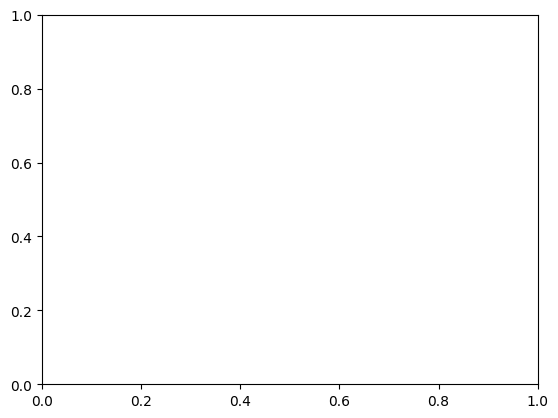

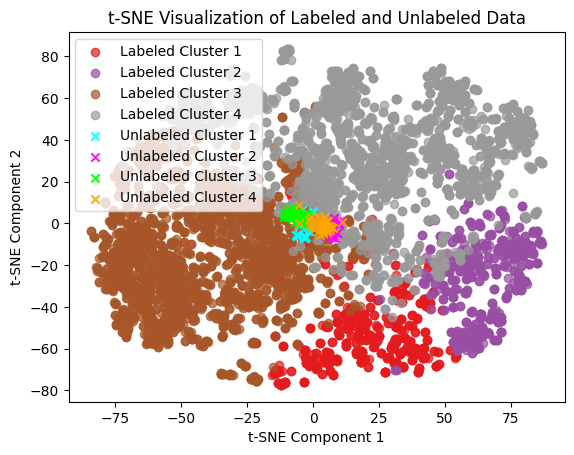

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Prepare original dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Load unlabeled dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labelled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Prepare images and labels for labelled dataset
img_all = []
label_all = []
for data, lab in dataset_:
    img_all.append(np.array(data)[0, :, :])
    label_all.append(lab)

img_all = np.array(img_all).reshape(len(dataset_), 28 * 28)
label_all = np.array(label_all)

# Perform t-SNE dimensionality reduction on labelled data
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# KMeans clustering on labeled data (4 clusters)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(img_all)
labeled_cluster_centers = kmeans.cluster_centers_

# Process the new dataset (unlabeled data)
new_img_all = []
for data, _ in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])

new_img_all = np.array(new_img_all).reshape(len(new_dataset), 28 * 28)

# Predict clusters for new dataset using same number of clusters
new_cluster_labels = kmeans.predict(new_img_all)

# Compute distances from new samples to labeled cluster centers
distances = cdist(new_img_all, labeled_cluster_centers, metric='euclidean')

# Select 10% least similar samples from each cluster
selected_indices = []
for cluster_id in range(num_clusters):
    cluster_indices = np.where(new_cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]

    # Get the 10% most distant samples (least similar)
    num_samples_to_select = max(1, int(len(cluster_indices) * 0.10))
    least_similar_indices = cluster_indices[np.argsort(cluster_distances)[-num_samples_to_select:]]

    selected_indices.extend(least_similar_indices)

print(f"Number of least similar samples selected: {len(selected_indices)}")

# Perform t-SNE on new selected dataset
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all[selected_indices])

# Plot the original labeled dataset t-SNE visualization
fig, ax = plt.subplots()

# Define a colormap to ensure consistent colors across clusters
colormap = plt.cm.get_cmap('Set1', num_clusters)

# Define color maps for labeled and unlabeled data
colormap_labeled = plt.cm.get_cmap('Set1', num_clusters)  # For labeled data
colormap_unlabeled = ['cyan', 'magenta', 'lime', 'orange']  # Different colors for unlabeled data

# Plot the original labeled dataset with default colors
fig, ax = plt.subplots()

# Plot labeled data with assigned cluster colors
for cluster_id in range(num_clusters):
    cluster_mask = (kmeans.labels_ == cluster_id)
    ax.scatter(X_embedded[cluster_mask, 0], X_embedded[cluster_mask, 1],
               c=[colormap_labeled(cluster_id)], label=f"Labeled Cluster {cluster_id + 1}", alpha=0.7)

# Plot the new dataset samples with different colors and 'x' marker
for cluster_id in range(num_clusters):
    cluster_mask = (new_cluster_labels[selected_indices] == cluster_id)
    ax.scatter(X_new_embedded[cluster_mask, 0], X_new_embedded[cluster_mask, 1],
               c=colormap_unlabeled[cluster_id], marker='x',
               label=f"Unlabeled Cluster {cluster_id + 1}", alpha=0.9)

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and Unlabeled Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()



Sample size of labeled training dataset: 5712
Sample size of new dataset: 1311
Total dimension after t-SNE reduction: (5712, 2)
Number of least similar samples selected: 130


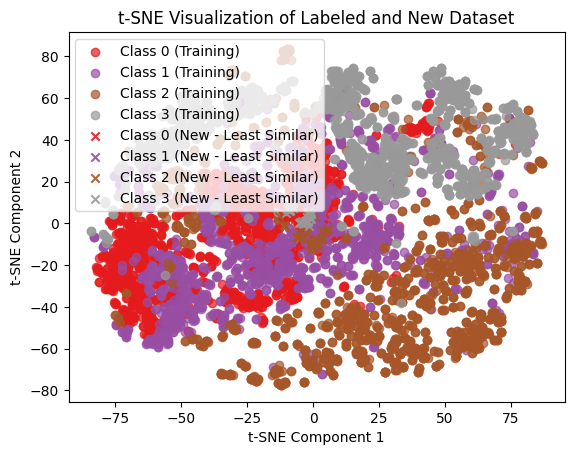

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# Define normalization for both datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Load the original labeled dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Load the new dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labeled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Extract labeled data features and labels
img_all = []
label_all = []
for data, lab in dataset_:
    img_all.append(np.array(data)[0, :, :])  # Take first channel
    label_all.append(lab)

img_all = np.array(img_all).reshape(len(dataset_), 28 * 28)
label_all = np.array(label_all)

# Extract new dataset features and labels
new_img_all = []
new_label_all = []
for data, lab in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])
    new_label_all.append(lab)

new_img_all = np.array(new_img_all).reshape(len(new_dataset), 28 * 28)
new_label_all = np.array(new_label_all)

# Perform t-SNE dimensionality reduction for visualization
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Compute class-wise centroids from the labeled dataset
unique_classes = np.unique(label_all)
class_centroids = {}

for class_id in unique_classes:
    class_samples = img_all[label_all == class_id]
    class_centroids[class_id] = np.mean(class_samples, axis=0)

# Compute distances from new samples to their respective class centroids
selected_indices = []

for class_id in unique_classes:
    # Get all samples from new dataset belonging to this class
    new_class_indices = np.where(new_label_all == class_id)[0]
    new_class_samples = new_img_all[new_class_indices]

    # Compute distance to the respective class centroid
    distances = cdist(new_class_samples, class_centroids[class_id].reshape(1, -1), metric='euclidean').flatten()

    # Select 10% least similar samples (most distant from centroid)
    num_samples_to_select = max(1, int(len(new_class_indices) * 0.10))
    least_similar_indices = new_class_indices[np.argsort(distances)[-num_samples_to_select:]]

    selected_indices.extend(least_similar_indices)

print(f"Number of least similar samples selected: {len(selected_indices)}")

# Perform t-SNE for selected samples
X_selected_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all[selected_indices])

# Plot original dataset t-SNE visualization
fig, ax = plt.subplots()

# Define colormap to ensure consistency
colormap = plt.cm.get_cmap('Set1', len(unique_classes))

# Plot labeled dataset with their known class labels
for class_id in unique_classes:
    class_mask = (label_all == class_id)
    ax.scatter(X_embedded[class_mask, 0], X_embedded[class_mask, 1],
               c=[colormap(class_id)], label=f"Class {class_id} (Training)", alpha=0.7)

# Plot new dataset samples with distinct colors and 'x' marker for selected least similar samples
for class_id in unique_classes:
    class_mask = (new_label_all[selected_indices] == class_id)
    ax.scatter(X_selected_embedded[class_mask, 0], X_selected_embedded[class_mask, 1],
               c=[colormap(class_id)], marker='x',
               label=f"Class {class_id} (New - Least Similar)", alpha=0.9)

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and New Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()


Sample size of labelled training dataset: 5712
Sample size of new dataset: 1311
Number of least similar samples selected: 129


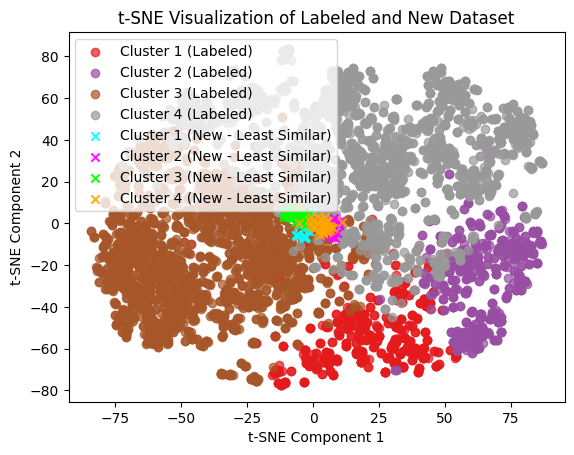

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Define normalization for both datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Load the labeled training dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

# Load the unlabeled dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labelled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Extract features and labels from the labeled dataset
img_all = []
label_all = []
for data, lab in dataset_:
    img_all.append(np.array(data)[0, :, :])  # Take first channel from tensor
    label_all.append(lab)

img_all = np.array(img_all).reshape(len(dataset_), 28 * 28)
label_all = np.array(label_all)

# Extract features from the unlabeled dataset
new_img_all = []
for data, _ in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])

new_img_all = np.array(new_img_all).reshape(len(new_dataset), 28 * 28)

# Perform t-SNE dimensionality reduction for visualization of labeled data
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

# Apply KMeans clustering to the labeled dataset to find 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labeled_cluster_labels = kmeans.fit_predict(img_all)

# Predict clusters for the new dataset using the labeled dataset clusters
new_cluster_labels = kmeans.predict(new_img_all)

# Compute distances of new samples to cluster centers
distances = cdist(new_img_all, kmeans.cluster_centers_, metric='euclidean')

# Select 10% least similar samples from each cluster
selected_indices = []

for cluster_id in range(num_clusters):
    cluster_indices = np.where(new_cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]

    # Get the 10% most distant samples (least similar)
    num_samples_to_select = max(1, int(len(cluster_indices) * 0.10))
    least_similar_indices = cluster_indices[np.argsort(cluster_distances)[-num_samples_to_select:]]

    selected_indices.extend(least_similar_indices)

print(f"Number of least similar samples selected: {len(selected_indices)}")

# Perform t-SNE dimensionality reduction on selected new dataset samples
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all[selected_indices])

# Plot labeled dataset t-SNE visualization
fig, ax = plt.subplots()

# Define distinct colors for labeled and unlabeled datasets
colormap = plt.cm.get_cmap('Set1', num_clusters)
unlabeled_colors = ['cyan', 'magenta', 'lime', 'orange']

# Plot the original labeled dataset with assigned cluster colors
for cluster_id in range(num_clusters):
    cluster_mask = (labeled_cluster_labels == cluster_id)
    ax.scatter(X_embedded[cluster_mask, 0], X_embedded[cluster_mask, 1],
               c=[colormap(cluster_id)], label=f"Cluster {cluster_id + 1} (Labeled)", alpha=0.7)

# Plot the selected new dataset samples with different colors and 'x' marker
for cluster_id in range(num_clusters):
    cluster_mask = (new_cluster_labels[selected_indices] == cluster_id)
    ax.scatter(X_new_embedded[cluster_mask, 0], X_new_embedded[cluster_mask, 1],
               c=unlabeled_colors[cluster_id], marker='x',
               label=f"Cluster {cluster_id + 1} (New - Least Similar)", alpha=0.9)

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and New Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# Define normalization for both datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Load labeled training dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Load new unlabelled dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labeled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Extract features from the labeled dataset
img_all = []
for data, _ in dataset_:
    img_all.append(np.array(data)[0, :, :])  # Take the first channel

img_all = np.array(img_all).reshape(len(dataset_), 28 * 28)

# Extract features from the unlabelled dataset
new_img_all = []
for data, _ in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])

new_img_all = np.array(new_img_all).reshape(len(new_dataset), 28 * 28)

# Perform t-SNE dimensionality reduction on the labeled dataset
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Calculate distances from new dataset samples to all labeled samples
distances = cdist(new_img_all, img_all, metric='euclidean')

# Get the minimum distance for each sample in new_dataset
min_distances = np.min(distances, axis=1)

# Select the top 10% most distant (outlier) samples
num_outliers = max(1, int(len(new_dataset) * 0.10))
outlier_indices = np.argsort(min_distances)[-num_outliers:]  # Get farthest samples

# Perform t-SNE on selected outlier samples
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(new_img_all[outlier_indices])

# Plot original labeled dataset t-SNE visualization
fig, ax = plt.subplots()

# Plot labeled data points in blue
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], color='blue', alpha=0.6, label="Labeled Data")

# Plot selected outlier points from new dataset in red
# ax.scatter(X_new_embedded[:, 0], X_new_embedded[:, 1], color='red', marker='x', label="Unlabeled Outliers")

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and New Dataset (Outliers Highlighted)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()


FileNotFoundError: [Errno 2] No such file or directory: '/content/braintumor/Training'

Sample size of labeled training dataset: 5712
Sample size of new dataset: 1311
Total dimension after t-SNE reduction: (7023, 2)
Number of outlier samples selected: 131


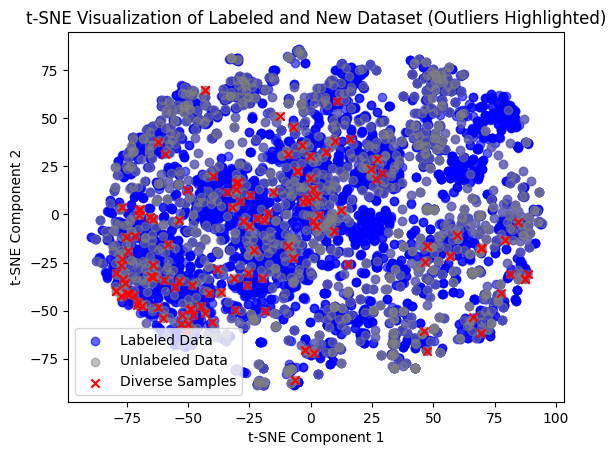

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# Define normalization for both datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Load labeled training dataset
dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    normalize,
]))

# Load new unlabelled dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize,
]))

print('Sample size of labeled training dataset:', len(dataset_))
print('Sample size of new dataset:', len(new_dataset))

# Extract features from both datasets and flatten them
img_all = []
for data, _ in dataset_:
    img_all.append(np.array(data)[0, :, :])  # Take the first channel

new_img_all = []
for data, _ in new_dataset:
    new_img_all.append(np.array(data)[0, :, :])

# Combine both datasets into a single array for joint embedding
combined_images = np.vstack((np.array(img_all).reshape(len(dataset_), -1),
                             np.array(new_img_all).reshape(len(new_dataset), -1)))

# Perform t-SNE on the combined dataset
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(combined_images)

# Separate the embedded data back into original datasets
X_labeled_embedded = X_embedded[:len(dataset_)]   # Labeled data embeddings
X_new_embedded = X_embedded[len(dataset_):]  # New data embeddings

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Calculate distances from new dataset samples to labeled dataset samples
distances = cdist(X_new_embedded, X_labeled_embedded, metric='euclidean')

# Get the minimum distance for each sample in the new dataset
min_distances = np.min(distances, axis=1)

# Select the top 10% most distant (outlier) samples
num_outliers = max(1, int(len(new_dataset) * 0.10))
outlier_indices = np.argsort(min_distances)[-num_outliers:]  # Get farthest samples

print(f"Number of outlier samples selected: {len(outlier_indices)}")

# Plot the labeled and new dataset samples together
fig, ax = plt.subplots()

# Plot labeled dataset (blue color)
ax.scatter(X_labeled_embedded[:, 0], X_labeled_embedded[:, 1], color='blue', alpha=0.6, label="Labeled Data")

# Plot all new dataset samples (gray)
ax.scatter(X_new_embedded[:, 0], X_new_embedded[:, 1], color='gray', alpha=0.5, label="Unlabeled Data")

# Highlight selected outliers (red)
ax.scatter(X_new_embedded[outlier_indices, 0], X_new_embedded[outlier_indices, 1],
           color='red', marker='x', label="Diverse Samples")

# Add legend and labels
ax.set_title('t-SNE Visualization of Labeled and New Dataset (Outliers Highlighted)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()
